# **APPLIED STATISTICS PROJECT**

## **Preprocessing_RNA**

## Useful libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import mudata
import scanpy as sc
import anndata as ad
from anndata import AnnData
from joblib import Parallel, delayed
from tqdm import tqdm

## File upload

In [2]:
# Import dataset
rna_data = sc.read_h5ad("/Users/eli/Desktop/progetto applied/dataset_applied/sampled_full_AML_RNA.h5ad")
adt_data=sc.read_h5ad("/Users/eli/Desktop/progetto applied/dataset_applied/sampled_full_AML_ADT.h5ad")
anno_df = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/Las_AML_annoatation.csv", header=None,names=["cell_id", "patient_id", "cell_type"])

# Remove blank spaces or not-allowed characters, clean
anno_df["cell_id"] = anno_df["cell_id"].str.strip()

## Printing some information about the datasets

In [3]:
# Print dataset dimensions
print(rna_data.shape)
print(anno_df.shape)

(211969, 36601)
(211970, 3)


In [4]:
# Head of rna_data to see an example of the dataset
print(rna_data.obs.head())

                                     sample  n_genes  n_counts  \
AACCAACCATGAAGGC-1_SRR16208932  SRR16208932      635     987.0   
AGACCCGAGAATACAC-1_SRR16208931  SRR16208931     1344    2633.0   
TGCACGGAGTAGTCTC-1_SRR16208932  SRR16208932     2327    6229.0   
CTTTCAAGTATATGGA-1_SRR16208932  SRR16208932     2159    5719.0   
ACCAAACTCGTTTACT-1_SRR16208930  SRR16208930      783    1400.0   

                                n_genes_by_counts  log1p_n_genes_by_counts  \
AACCAACCATGAAGGC-1_SRR16208932                635                 6.455199   
AGACCCGAGAATACAC-1_SRR16208931               1344                 7.204149   
TGCACGGAGTAGTCTC-1_SRR16208932               2327                 7.752765   
CTTTCAAGTATATGGA-1_SRR16208932               2159                 7.677864   
ACCAAACTCGTTTACT-1_SRR16208930                783                 6.664409   

                                total_counts  log1p_total_counts  \
AACCAACCATGAAGGC-1_SRR16208932         987.0            6.895683  

In [5]:
# Number of samples in rna_data
num_sample_RNA= rna_data.obs["sample_demult"].nunique()

print(f"Number of samples in RNA: {num_sample_RNA}")

Number of samples in RNA: 32


In [6]:
# Columns of each data frame
print(rna_data.obs.columns)

Index(['sample', 'n_genes', 'n_counts', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'outlier',
       'doublet_scores_scrublet', 'predicted_doublets_scrublet',
       'sample_demult', 'age'],
      dtype='object')


## Building a new dataset grouping by cell type and patient with MEDIAN

In [7]:
# Make sure that IDs coincide
rna_data.obs['cell_id'] = rna_data.obs_names

# Merge annotations about cells
rna_data.obs = rna_data.obs.merge(anno_df, on='cell_id', how='left')

In [8]:
# Extract the expression matrix from the AnnData object
expr = rna_data.to_df()

# Append metadata 
expr['patient_id'] = rna_data.obs['patient_id'].values
expr['cell_type'] = rna_data.obs['cell_type'].values

# Select only numeric columns (gene expression values)
numeric_cols = expr.select_dtypes(include=[np.number]).columns

# List of unique patient IDs
unique_patients = expr['patient_id'].unique()

# Function to process a single patient: compute median expression per cell type
def process_patient_np(pid):
    patient_df = expr[expr['patient_id'] == pid]

    # Group by cell type and compute the median gene expression
    grouped = patient_df.groupby('cell_type')[numeric_cols].agg(np.median)

    # Retain patient ID for index reconstruction
    grouped['patient_id'] = pid

    return grouped.reset_index()  

# Parallel execution across all patients 
results = Parallel(n_jobs=8)(
    delayed(process_patient_np)(pid) for pid in tqdm(unique_patients)
)

# Combine all results into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)

# Set multi-index: (patient_id, cell_type)
combined_df = combined_df.set_index(['patient_id', 'cell_type'])
combined_df = combined_df.copy()

print("Final shape:", combined_df.shape)


 35%|███▍      | 8/23 [00:19<00:00, 59.74it/s]/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/2945878545.py:22: FutureWarning: The provided callable <function median at 0x102210790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/2945878545.py:22: FutureWarning: The provided callable <function median at 0x102034790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/2945878545.py:22: FutureWarning: The provided callable <function median at 0x10565c790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current beha

Final shape: (434, 36601)


In [9]:
# Save DataFrame
combined_df.to_csv("median_expression.csv")

### Add AGE to the median dataset

In [ ]:
median_data = pd.read_csv('/Users/eli/Desktop/progetto applied/dataset_applied/median_expression.csv')

In [11]:
print(f"Shape: {median_data.shape}")

Shape: (434, 36603)


In [30]:
# Display a few (num_cols) columns to verify the correctness of the generated DataFrame
num_cols = 5

# Randomly select a subset of numeric columns 
random_cols = np.random.choice(median_data.columns, size=num_cols, replace=False)

# Print 5 random rows from the selected columns
print(median_data[random_cols].sample(5))

     AC243829.5    CAMTA1  CD8B       TPR  GPN1
146         0.0  1.020917   0.0  0.863037   0.0
307         0.0  0.000000   0.0  0.000000   0.0
106         0.0  0.000000   0.0  0.000000   0.0
323         0.0  0.403792   0.0  0.462323   0.0
124         0.0  0.329250   0.0  0.288220   0.0


In [31]:
# Create a dictionary mapping each patient_id to its corresponding age category

patient_to_age = {
    'SRR16208932': 'Pediatric_AML',
    'SRR16208931': 'Pediatric_AML',
    'SRR16208930': 'Pediatric_AML',
    'SRR16208925': 'CNTRL',
    'SRR16208927': 'CNTRL',
    'SRR16208926': 'CNTRL',
    'SRR16208924': 'CNTRL',
    'SRR16208937': 'Pediatric_AML',
    'SRR16208938': 'Pediatric_AML',
    'SRR16208942': 'Pediatric_AML',
    'SRR16208941': 'Pediatric_AML',
    'SRR16208929': 'Adult_AML',
    'SRR16208928': 'Adult_AML',
    'SRR16208948': 'Pediatric_AML',
    'SRR16208947': 'CNTRL',
    'SRR16208946': 'CNTRL',
    'SRR16208943': 'Adult_AML',
    'SRR16208944': 'Adult_AML',
    'SRR16208940': 'Pediatric_AML',
    'SRR16208939': 'Pediatric_AML',
    'SRR16208923': 'Adult_AML',
    'SRR16208921': 'Adult_AML',
    'SRR16208922': 'Adult_AML'
}

# Function to retrieve age category given a patient_id
def get_age(patient_id):
    return patient_to_age.get(patient_id, 'Unknown')  # Returns 'Unknown' if patient_id is not found

# Apply the get_age function to each row using the 'patient_id' column
median_data['age'] = median_data['patient_id'].apply(lambda x: get_age(x))

# Reorder the columns to place 'age' as the third column
cols = median_data.columns.tolist()
cols.remove('age')
cols.insert(2, 'age')
median_data = median_data[cols]

# Save the updated DataFrame to a new CSV file
median_data.to_csv("median_with_age.csv", index=False)



## PCA on Rna dataset

### Build AnnData dataset

In [14]:
rna_data = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/median_with_age.csv")

In [15]:
# Display some rows and columns of the dataset
rna_data.head

<bound method NDFrame.head of       patient_id           cell_type            age  MIR1302-2HG  FAM138A  \
0    SRR16208932              B cell  Pediatric_AML          0.0      0.0   
1    SRR16208932              B_prog  Pediatric_AML          0.0      0.0   
2    SRR16208932                 CLP  Pediatric_AML          0.0      0.0   
3    SRR16208932           Early GMP  Pediatric_AML          0.0      0.0   
4    SRR16208932           Erythroid  Pediatric_AML          0.0      0.0   
..           ...                 ...            ...          ...      ...   
429  SRR16208922             Pre-cDC      Adult_AML          0.0      0.0   
430  SRR16208922             Pre-pDC      Adult_AML          0.0      0.0   
431  SRR16208922             ProMono      Adult_AML          0.0      0.0   
432  SRR16208922  Progenitor_Cycling      Adult_AML          0.0      0.0   
433  SRR16208922              T cell      Adult_AML          0.0      0.0   

     OR4F5  AL627309.1  AL627309.3  AL627309.

In [16]:
# Create AnnData dataset
# Extract gene columns
genes_only = rna_data.drop(columns=['patient_id', 'cell_type', 'age'])

data = AnnData(genes_only.values)

# Add metadata
data.obs = rna_data[['patient_id', 'cell_type', 'age']]


### 100 PCs components

In [17]:
sc.tl.pca(data, n_comps=100, svd_solver='arpack')

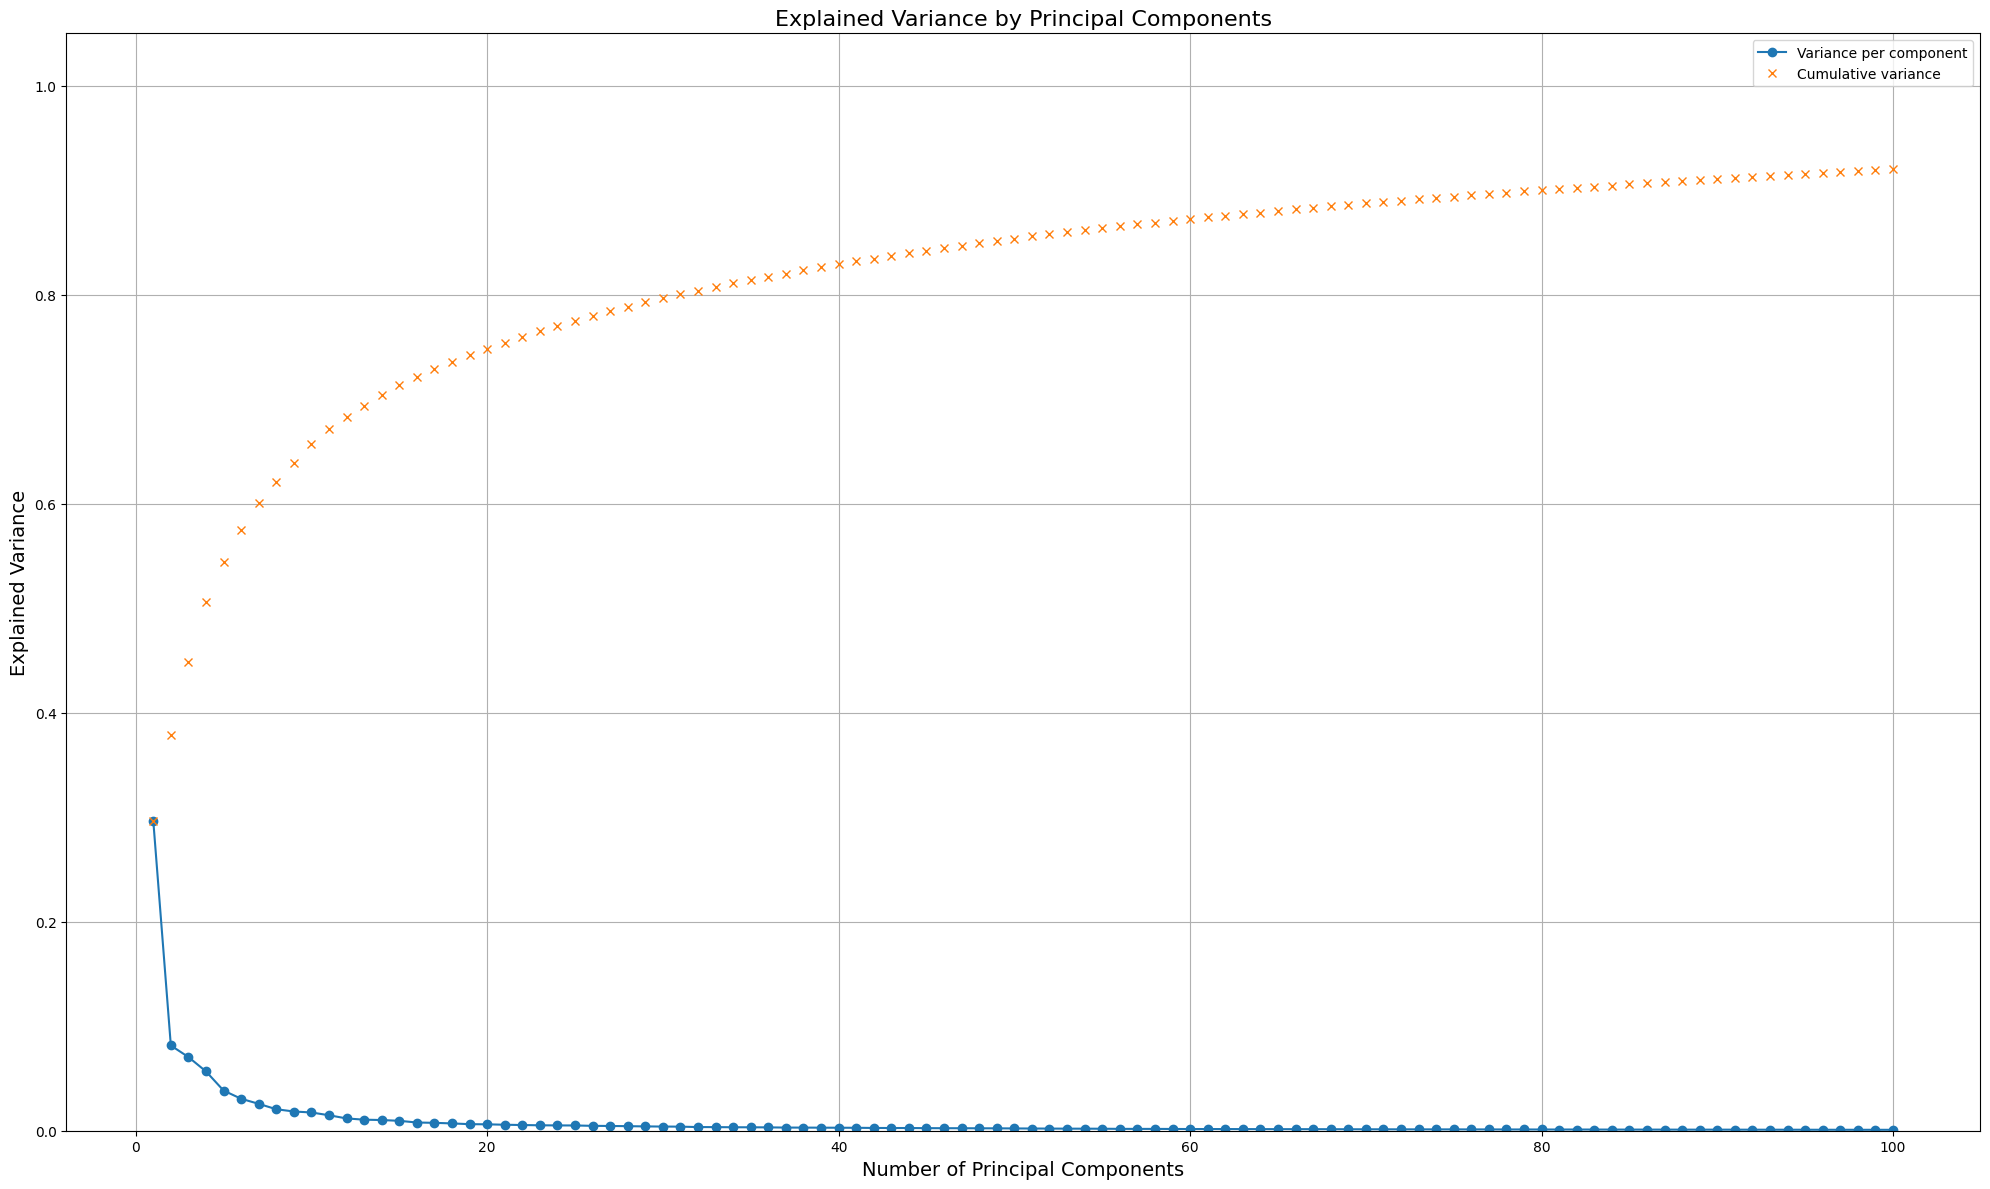

In [18]:
# Make variance plot
pca_variance_ratio = data.uns['pca']['variance_ratio']
cumulative_variance = np.cumsum(pca_variance_ratio)

# Plot
plt.figure(figsize=(20, 12))
plt.plot(range(1, len(pca_variance_ratio) + 1), pca_variance_ratio, marker='o', label='Variance per component')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', linestyle='', label='Cumulative variance')

plt.title('Explained Variance by Principal Components', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)

plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Take first 30 components from data.obsm['X_pca']
pca_array = data.obsm['X_pca'][:, :30]

# Build a new DataFrame with these 30 components
pca_scores = pd.DataFrame(
    pca_array,
    columns=[f'PC{i+1}' for i in range(pca_array.shape[1])]
)

# Add metadata
pca_scores['patient_id'] = data.obs['patient_id'].values
pca_scores['age'] = data.obs['age'].values
pca_scores['cell_type'] = data.obs['cell_type'].values

ordered_columns = ['patient_id', 'age', 'cell_type'] + [col for col in pca_scores.columns if col.startswith('PC')]
pca_scores = pca_scores[ordered_columns]

# Save the DataFrame
pca_scores.to_csv('rna_scores_30pcs.csv', index=True)

In [20]:
# Save the loadings of the principal components
loadings_array = data.varm['PCs'][:, :30]  # tutte le variabili, prime 30 componenti

loadings_df = pd.DataFrame(
    loadings_array,
    columns=[f'PC{i+1}' for i in range(loadings_array.shape[1])],
    index=rna_data.drop(columns=['patient_id', 'cell_type', 'age']).columns  # nomi geni
)

loadings_df.to_csv("rna_loadings_30pcs.csv")

## **Preprocessing_ADT**

## Print some info about this dataset

In [21]:
print(adt_data)
print(adt_data.obs.head())
print(adt_data.to_df().head())

AnnData object with n_obs × n_vars = 211969 × 61
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'sample_demult'
    var: 'gene_symbol', 'gene_id'
    obsm: 'uninteg_UMAP'
    layers: 'raw_counts'
                                     sample  n_genes_by_counts  \
AACCAACCATGAAGGC-1_SRR16208932  SRR16208932                 65   
AGACCCGAGAATACAC-1_SRR16208931  SRR16208931                 65   
TGCACGGAGTAGTCTC-1_SRR16208932  SRR16208932                 62   
CTTTCAAGTATATGGA-1_SRR16208932  SRR16208932                 53   
ACCAAACTCGTTTACT-1_SRR16208930  SRR16208930                 60   

                                log1p_n_genes_by_counts  total_counts  \
AACCAACCATGAAGGC-1_SRR16208932                 4.189655        1472.0   
AGACCCGAGAATACAC-1_SRR16208931                 4.189655         847.0   
TGCACGGAGTAGTCTC-1_SRR16208932                 4.143135         324.0   
CTTTCAAGTATATGGA-1_SRR16208932                 3.988984  

In [22]:
adt_data.obs['cell_id'] = adt_data.obs_names
adt_data.obs = adt_data.obs.merge(anno_df, on='cell_id', how='left')

In [23]:
# Extract the protein expression matrix from the adt_data object
expr = adt_data.to_df()

# Add metadata columns to the DataFrame 
expr['patient_id'] = adt_data.obs['patient_id'].values
expr['cell_type'] = adt_data.obs['cell_type'].values

# Select only numeric columns
numeric_cols = expr.select_dtypes(include=[np.number]).columns

# List of unique patient IDs
unique_patients = expr['patient_id'].unique()

# Function to process one patient at a time
def process_patient_np(pid):
    patient_df = expr[expr['patient_id'] == pid]

    # Group by cell type and compute the median
    grouped = patient_df.groupby('cell_type')[numeric_cols].agg(np.median)

    # Add patient_id as a column for reconstructing the index later
    grouped['patient_id'] = pid

    return grouped.reset_index()  

# Apply the function in parallel 
results = Parallel(n_jobs=8)(
    delayed(process_patient_np)(pid) for pid in tqdm(unique_patients)
)

# Combine all the results into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)

# Reconstruct the multi-level index (patient_id, cell_type)
combined_df = combined_df.set_index(['patient_id', 'cell_type'])

combined_df = combined_df.copy()

# Print final shape of the DataFrame
print("Final shape:", combined_df.shape)

# Save the aggregated dataset to CSV
combined_df.to_csv("protein_agg.csv")


100%|██████████| 23/23 [00:00<00:00, 472.74it/s]/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/953824232.py:24: FutureWarning: The provided callable <function median at 0x102034790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.

/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/953824232.py:24: FutureWarning: The provided callable <function median at 0x10565c790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
/var/folders/j6/lv3wvk8n4d5_56_n296yy_t00000gn/T/ipykernel_1220/953824232.py:24: FutureWarning: The provided callable <function median at 0x10793c790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current beha

Final shape: (434, 61)


## PCA on ADT dataset

In [24]:
# Import the dataset
adt_data = pd.read_csv("protein_agg.csv", index_col=[0, 1])

# Show a preview
print(adt_data.head())

                           CD1A      CD1C       CD2       CD3      CD4  \
patient_id  cell_type                                                    
SRR16208932 B cell     0.000000  0.434405  0.000000  0.536177  0.32829   
            B_prog     0.519078  0.434405  0.393461  0.883320  0.57503   
            CLP        0.859067  0.736248  0.675087  0.665748  0.32829   
            Early GMP  0.000000  0.434405  0.393461  0.665748  0.57503   
            Erythroid  0.259539  0.434405  0.393461  0.665748  0.45166   

                            CD5       CD7       CD8      CD10    CD11B  ...  \
patient_id  cell_type                                                   ...   
SRR16208932 B cell     0.743943  0.620490  0.609447  0.693831  0.41581  ...   
            B_prog     0.775710  0.620490  0.609447  1.446230  0.41581  ...   
            CLP        0.524808  0.620490  0.350450  0.405921  0.00000  ...   
            Early GMP  0.603311  0.620490  0.350450  0.405921  0.41581  ...   
       

### Performe PCA on the entire dataset

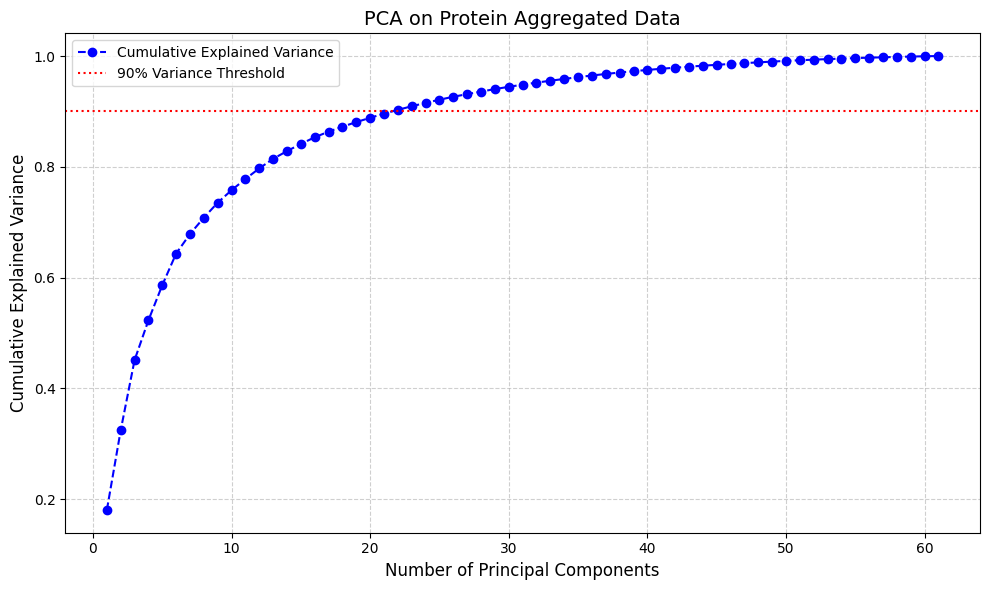

In [25]:
# Use only numerical features
X = adt_data.values 

# Perform PCA on the entire dataset
pca = PCA(n_components=min(X.shape))  
pca.fit(X)

# Compute cumulative explained variance
explained_variance_cum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_cum) + 1),
    explained_variance_cum,
    marker='o',
    linestyle='--',
    color='blue',
    label='Cumulative Explained Variance'
)

plt.axhline(y=0.9, color='red', linestyle=':', label='90% Variance Threshold')

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA on Protein Aggregated Data', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Find the number of components required to explain at least 90% of the variance
n_components_90 = np.argmax(explained_variance_cum >= 0.9) + 1
print(f"Number of components needed to explain ≥90% of the variance: {n_components_90}")

Number of components needed to explain ≥90% of the variance: 22


In [27]:
# Extract loadings of the first 10 PC
loadings = pca.components_[:10, :]  

feature_names = adt_data.columns  

# Create DataFrame of loadings
loadings_df = pd.DataFrame(loadings.T, index=feature_names,
                           columns=[f'PC{i+1}' for i in range(10)])

# For each PC ì, show the 10 best proteins
for pc in loadings_df.columns:
    print(f"\nTop 10 proteins for {pc}:")
    top_loadings = loadings_df[pc].abs().sort_values(ascending=False).head(10).index
    print(loadings_df.loc[top_loadings, pc])


Top 10 proteins for PC1:
CD141    0.275634
CD161    0.250325
CD163    0.238043
CD138    0.233269
CD152    0.226511
CD33     0.212143
CD2      0.211216
CD45     0.197272
CD11C    0.193357
CD48     0.191551
Name: PC1, dtype: float64

Top 10 proteins for PC2:
CD36     0.587041
CD33     0.370256
CD11C    0.280994
CD71     0.229347
CD61     0.188278
CD41     0.187569
CD161   -0.159693
CD7     -0.149206
CD2     -0.147119
CD152   -0.142408
Name: PC2, dtype: float64

Top 10 proteins for PC3:
CD2      0.315668
CD7      0.296807
CD5      0.280903
CD48     0.267011
CD141   -0.256621
CD138   -0.252177
CD163   -0.247950
CD152   -0.232486
CD45     0.229725
CD71    -0.222042
Name: PC3, dtype: float64

Top 10 proteins for PC4:
CD71      0.692758
CD33     -0.261363
CD2       0.247218
CD7       0.240422
CD36      0.224058
CD19     -0.213043
CD11C    -0.174825
CD22     -0.173089
HLA-DR   -0.164826
CD8       0.158938
Name: PC4, dtype: float64

Top 10 proteins for PC5:
CD19      0.454685
CD71      0.38408

### Create scores and loadings dataset

In [28]:
# Load the aggregated dataset as a DataFrame
adt_data = pd.read_csv("protein_agg.csv", index_col=[0, 1]) 

# Extract only the numeric columns 
X = adt_data.values 

# Perform PCA
pca = PCA(n_components=40)
X_pca_40 = pca.fit_transform(X)

# Create a DataFrame with the 40 principal components
df_pca_40 = pd.DataFrame(X_pca_40, columns=[f'PC{i+1}' for i in range(40)])

# Restore the original multi-index (patient_id, cell_type) and add age 
df_pca_40.index = adt_data.index

age_df = pd.read_csv("/Users/eli/Desktop/progetto applied/dataset_applied/patients_age.csv")  

df_pca_40 = df_pca_40.reset_index() 
df_pca_40 = df_pca_40.merge(age_df, on='patient_id', how='left')

cols = df_pca_40.columns.tolist()
cols.insert(2, cols.pop(cols.index('age')))
df_pca_40 = df_pca_40[cols]

df_pca_40 = df_pca_40.set_index(['patient_id', 'cell_type'])

# Save to CSV
df_pca_40.to_csv("pca_adt_40components_with_age.csv")

# Create loadings dataset
feature_names = adt_data.columns

# DataFrame of PCA loadings
loadings_df = pd.DataFrame(pca.components_.T,  # transpose to have proteins as rows
                           index=feature_names,
                           columns=[f'PC{i+1}' for i in range(40)])

# Save loadings to CSV
loadings_df.to_csv("pca_adt_40components_loadings.csv")